### Important Details about EEG data:
Sampple Frequency = 200 Hz

Number of Samples = 621892

Duration of trial = 0.85 seconds after onset, which is indicated by firs non-zero marker value from marker data.

### Signal Extraction and Feature Engineering

In [15]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import mne
import tensorflow as tf

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
sn.set_theme()

In [24]:
def mat_loader(file,var_list=['o'],def_inputs = False):
    '''
    file: string, path to file.
    var: list of string, name of element(s) in .mat 
    file to be extracted.
    return: dict holding one or more elements from specified var
    
    required libraries: scipy.io
    '''
    print('.mat file has the following elements',scipy.io.whosmat(file))
    mat_to_dict = {}
    for var in var_list:
        if def_inputs:
            print('Choose from first element from tuples in this list', 
                  scipy.io.whosmat(file))
            var = input('Input string label from above')
        mat_load = scipy.io.loadmat('CLA-SubjectJ-170508-3St-LRHand-Inter')
        keys = [e for e in dict(mat_load[var].dtype.fields).keys()]
        print('Structure had these keys:', keys)
        for i in range(len(keys)):
            mat_to_dict[keys[i]] = mat_load[var][0][0][i]
    return mat_to_dict

In [25]:
mat_dict = mat_loader('CLA-SubjectJ-170508-3St-LRHand-Inter',['o'])

.mat file has the following elements [('ans', (1, 1), 'double'), ('o', (1, 1), 'struct'), ('x', (533, 1), 'double')]
Structure had these keys: ['id', 'tag', 'nS', 'sampFreq', 'marker', 'marker_old', 'data', 'chnames', 'binsuV']


In [26]:
def eeg_data_loader(mat_loader,eeg_data='data',marker='marker',chan_names='chnames'):
    '''
    Takes in mat_loader, a dictionary with keys that map to eeg data information,
    and extracts data from the given eeg_data, marker, chan_names keys:
    
    mat_loader: dict, mapping labels to its respective eeg data
    eeg_data: string, dictionary key
    marker: string, dictionary key
    chan_names: string, dictionary key
    
    return: tuple with 3 elements, (raw_eeg_unfiltered, marker, chan_names)
    '''
    #Extract eeg data from .mat files
    raw_eeg_unfiltered = mat_loader[eeg_data].transpose()[:21,:]
    #^only takes the first 21 channels which are the actual EEG channels
    marker = mat_loader[marker]
    chan_names = mat_loader[chan_names]

    #format chan_names as a list to be used in that format for RawEEG function
    chan_names = [st[0][0] for st in chan_names]
    chan_names.append('STI 1')
    
    return (raw_eeg_unfiltered,marker,chan_names)

In [27]:
(raw_eeg_unfiltered,marker,chan_names) = eeg_data_loader(mat_dict)

In [28]:
def preprocessing(raw_eeg_unfiltered,marker,samp_freq=200,l_fq=1,h_fq=40):
    #Bandpass filter eeg data from 1 Hz to 40 Hz
    raw_eeg = mne.filter.filter_data(raw_eeg_unfiltered, samp_freq, l_fq, h_fq)
    
    #Make marker last EEG label
    raw_eeg = np.concatenate((raw_eeg, marker.flatten().reshape(1,-1)),axis=0)
    
    #Generate RawArray object to facilitate EEG analysis with mne
    eeg_raw = mne.io.RawArray(raw_eeg,info= mne.create_info(chan_names,samp_freq))
    print(eeg_raw.info)
    
    #Detect events in the data, containing 
    eeg_events = mne.find_events(eeg_raw,stim_channel='STI 1')
    #^ rows= n_events columns = (time,nothing,event_ID)
    
    #Extract epochs from raw EEG
    eeg_epochs = mne.Epochs(eeg_raw,eeg_events,
                        event_id=[1,2,3],
                        tmin=-0.2,tmax=0.8)
    
    return (eeg_raw, eeg_events, eeg_epochs)

In [29]:
(eeg_raw, eeg_events, eeg_epochs) = preprocessing(raw_eeg_unfiltered,marker)

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (3.305 sec)

Creating RawArray with float64 data, n_channels=22, n_times=621892
    Range : 0 ... 621891 =      0.000 ...  3109.455 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, A1, A2, F7, F8, T3, ...
 chs: 22 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 22
 projs: []
 sfreq: 200.0 Hz
>
900 events found
Event IDs: [1 2 3]
Not setting metadata
Not setting metadata
900 matching e

In [30]:
#Obtain epochs and labels for each epoch
np_epochs = eeg_epochs.get_data(picks=eeg_raw.info.ch_names[:-1])

df_epochs = eeg_epochs.to_data_frame(picks='all')
labels = []
for i in df_epochs['epoch'].unique():
    labels.append(np.array(df_epochs['condition'][df_epochs['epoch'] == i])[0])

X_train, X_test, y_train, y_test = train_test_split(np_epochs, labels, test_size=0.20, random_state=42)
y_true = y_test

#Reshape X as (epochs,time steps,features) from original (epochs,features,time_setp)
X_train = np.transpose(X_train, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))

#One-hot-encode train labels
y_train = tf.keras.utils.to_categorical(y_train) 
y_test = tf.keras.utils.to_categorical(y_test)

print(X_test.shape)
print(y_test.shape)

Loading data for 900 events and 201 original time points ...
0 bad epochs dropped
Loading data for 900 events and 201 original time points ...
(180, 201, 21)
(180, 4)


In [31]:
class eegRNN(tf.keras.Model):
    def __init__(self,n_timesteps,n_features,n_outputs):
        super().__init__()
        self.n_timesteps = n_timesteps
        self.n_features = n_features
        self.n_outputs =  n_outputs
        
        self.rnn1 = tf.keras.layers.LSTM(20, return_sequences=True,input_shape= 
                                         (self.n_timesteps,self.n_features))
        self.rnn2 = tf.keras.layers.LSTM(20,return_sequences=True)
        self.rnn3 = tf.keras.layers.LSTM(20)
        self.rnn_fc = tf.keras.layers.Dense(self.n_outputs, activation='softmax')
        
    def call(self,inputs):
        '''
        inputs: np.array with shape [batch, timesteps, feature]
        '''
        l = self.rnn1(inputs)
        l = self.rnn2(l)
        l = self.rnn3(l)
        l = self.rnn_fc(l)
        return l    

In [32]:
rnn_model = eegRNN(X_train.shape[1],X_train.shape[2],y_train.shape[1])
rnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, epochs= 30, batch_size = 50)

Epoch 1/30
15/15 [==============================] - 7s 116ms/step - loss: 1.3225 - accuracy: 0.3403
Epoch 2/30
15/15 [==============================] - 2s 111ms/step - loss: 1.1926 - accuracy: 0.4083
Epoch 3/30
15/15 [==============================] - 2s 110ms/step - loss: 1.0986 - accuracy: 0.4500
Epoch 4/30
15/15 [==============================] - 2s 110ms/step - loss: 1.0149 - accuracy: 0.5208
Epoch 5/30
15/15 [==============================] - 2s 111ms/step - loss: 0.8789 - accuracy: 0.6222
Epoch 6/30
15/15 [==============================] - 2s 110ms/step - loss: 0.7419 - accuracy: 0.7111
Epoch 7/30
15/15 [==============================] - 2s 112ms/step - loss: 0.6803 - accuracy: 0.7333
Epoch 8/30
15/15 [==============================] - 2s 109ms/step - loss: 0.5728 - accuracy: 0.7861
Epoch 9/30
15/15 [==============================] - 2s 115ms/step - loss: 0.5022 - accuracy: 0.8222
Epoch 10/30
15/15 [==============================] - 2s 109ms/step - loss: 0.4477 - accuracy: 0.8431

In [ ]:
rnn_model.save('RNN_model')

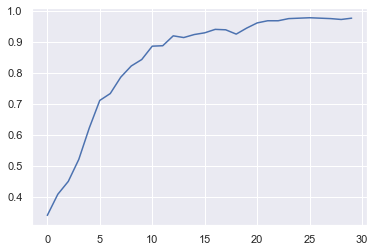

In [34]:
plt.plot(rnn_history.history['accuracy'])

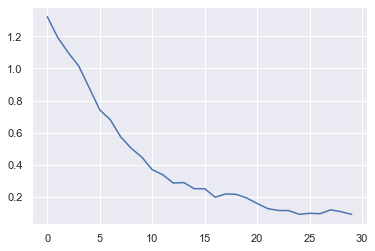

In [35]:
plt.plot(rnn_history.history['loss'])

In [36]:
accuracy = rnn_model.evaluate(X_test, y_test)

6/6 [==============================] - 1s 28ms/step - loss: 0.7091 - accuracy: 0.7889


<AxesSubplot:>

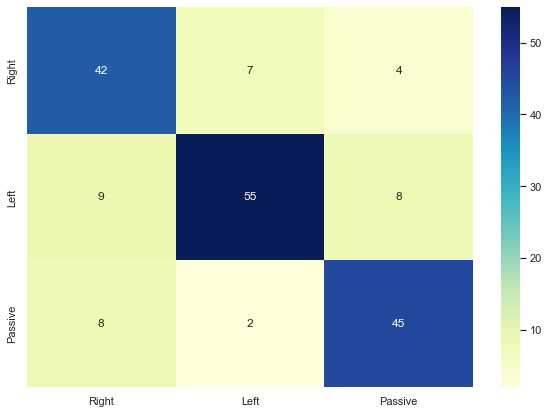

In [37]:
predictions = rnn_model.predict(X_test)
y_pred = [p.argmax() for p in predictions]
y_true = [y.argmax() for y in y_test]
conf_mat = confusion_matrix(y_true,y_pred)
df_conf = pd.DataFrame(conf_mat,index=[i for i in 'Right Left Passive'.split()],
                      columns = [i for i in 'Right Left Passive'.split()])
plt.figure(figsize = (10,7))
sn.heatmap(df_conf, annot=True,cmap='YlGnBu')

In [38]:
class eegCNN(tf.keras.Model):
    def __init__(self,n_timesteps,n_features,n_outputs):
        super().__init__()
        self.n_timesteps = n_timesteps
        self.n_features = n_features
        self.n_outputs =  n_outputs
        
        self.conv1 = tf.keras.layers.Conv1D(filters=50,kernel_size=3,activation='relu',
                                           input_shape=[self.n_timesteps,self.n_features])
        self.pool1 = tf.keras.layers.MaxPooling1D(pool_size=3)
        self.conv2 = tf.keras.layers.Conv1D(filters=100,kernel_size=3,activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling1D(pool_size=3)
        self.conv3 = tf.keras.layers.Conv1D(filters=200,kernel_size=3,activation='relu')
        self.pool3 = tf.keras.layers.MaxPooling1D(pool_size=3)
        self.flat = tf.keras.layers.Flatten()
        self.fc = tf.keras.layers.Dense(self.n_outputs, activation='softmax')
        
    def call(self,inputs):
        e = self.conv1(inputs)
        e = self.pool1(e)
        e = self.conv2(e)
        e = self.pool2(e)
        e = self.conv3(e)
        e = self.pool3(e)
        e = self.flat(e)
        return self.fc(e)

In [39]:
cnn_model = eegCNN(X_train.shape[1],X_train.shape[2],y_train.shape[1])
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs= 20, batch_size = 50)

Epoch 1/20
15/15 [==============================] - 1s 12ms/step - loss: 1.7616 - accuracy: 0.4722
Epoch 2/20
15/15 [==============================] - 0s 12ms/step - loss: 0.5151 - accuracy: 0.7931
Epoch 3/20
15/15 [==============================] - 0s 12ms/step - loss: 0.2805 - accuracy: 0.8875
Epoch 4/20
15/15 [==============================] - 0s 12ms/step - loss: 0.1755 - accuracy: 0.9417
Epoch 5/20
15/15 [==============================] - 0s 13ms/step - loss: 0.1224 - accuracy: 0.9667
Epoch 6/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0938 - accuracy: 0.9833
Epoch 7/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0607 - accuracy: 0.9917
Epoch 8/20
15/15 [==============================] - 0s 11ms/step - loss: 0.0450 - accuracy: 0.9972
Epoch 9/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0313 - accuracy: 0.9986
Epoch 10/20
15/15 [==============================] - 0s 12ms/step - loss: 0.0210 - accuracy: 1.0000
Epoch 11/

In [ ]:
#Saving model in Keras:
cnn_model.save('CNN_model')

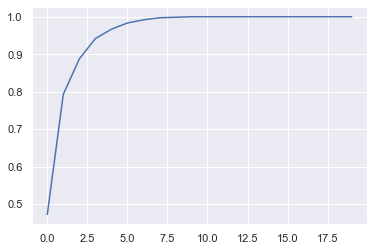

In [44]:
plt.plot(cnn_history.history['accuracy'])

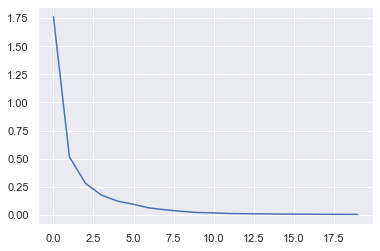

In [45]:
plt.plot(cnn_history.history['loss'])

In [46]:
accuracy = cnn_model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 4ms/step - loss: 0.3930 - accuracy: 0.8889


<AxesSubplot:>

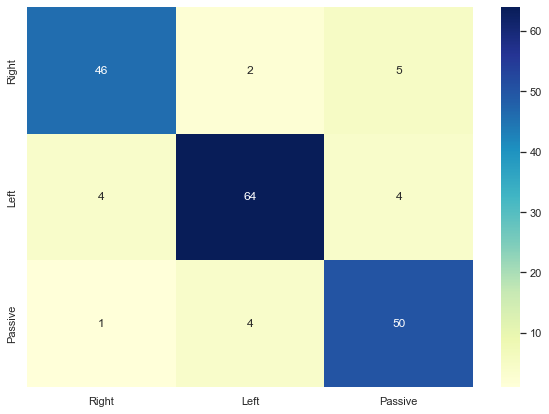

In [48]:
predictions = cnn_model.predict(X_test)
y_pred = [p.argmax() for p in predictions]
y_true = [y.argmax() for y in y_test]
conf_mat = confusion_matrix(y_true,y_pred)
df_conf = pd.DataFrame(conf_mat,index=[i for i in 'Right Left Passive'.split()],
                      columns = [i for i in 'Right Left Passive'.split()])
plt.figure(figsize = (10,7))
sn.heatmap(df_conf, annot=True,cmap='YlGnBu')

In [49]:
class eegConvRNN(tf.keras.Model):
    def __init__(self,n_timesteps,n_features,n_outputs):
        super().__init__(n_timesteps,n_features,n_outputs)
        self.n_timesteps = n_timesteps
        self.n_features = n_features
        self.n_outputs =  n_outputs
        
        #RNN Network
        self.rnn1 = tf.keras.layers.LSTM(20, return_sequences=True,input_shape= 
                                         (self.n_timesteps,self.n_features))
        self.rnn2 = tf.keras.layers.LSTM(20,return_sequences=True)
        self.rnn3 = tf.keras.layers.LSTM(20)
        self.rnn_fc = tf.keras.layers.Dense(self.n_outputs, activation='softmax')
        
        #CNN Network
        self.conv1 = tf.keras.layers.Conv1D(filters=50,kernel_size=3,activation='relu',
                                           input_shape=[self.n_timesteps,self.n_features])
        self.pool1 = tf.keras.layers.MaxPooling1D(pool_size=3)
        self.conv2 = tf.keras.layers.Conv1D(filters=100,kernel_size=3,activation='relu')
        self.pool2 = tf.keras.layers.MaxPooling1D(pool_size=3)
        self.conv3 = tf.keras.layers.Conv1D(filters=200,kernel_size=3,activation='relu')
        self.pool3 = tf.keras.layers.MaxPooling1D(pool_size=3)
        self.flat = tf.keras.layers.Flatten()
        self.cnn_fc = tf.keras.layers.Dense(self.n_outputs, activation='softmax')
        
        #Averaged Outuput Layer
        self.avg = tf.keras.layers.Average()
        self.fc_out = tf.keras.layers.Dense(self.n_outputs, activation='softmax')
        
    def call(self,inputs):
        '''
        inputs: np.array with shape [batch, timesteps, feature]
        '''
        #RNN operations
        l = self.rnn1(inputs)
        l = self.rnn2(l)
        l = self.rnn3(l)
        l = self.rnn_fc(l)
        
        #CNN operations
        e = self.conv1(inputs)
        e = self.pool1(e)
        e = self.conv2(e)
        e = self.pool2(e)
        e = self.conv3(e)
        e = self.pool3(e)
        e = self.flat(e)
        e = self.cnn_fc(e)
        
        #Averaged Output Layer
        out = self.avg([l,e])
        return self.fc_out(out)        

In [54]:
c_rnnModel = eegConvRNN(X_train.shape[1],X_train.shape[2],y_train.shape[1])
c_rnnModel.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
crnn_history = c_rnnModel.fit(X_train, y_train, epochs= 100, batch_size = 70)

Epoch 1/100
11/11 [==============================] - 8s 131ms/step - loss: 1.3674 - accuracy: 0.3569
Epoch 2/100
11/11 [==============================] - 1s 133ms/step - loss: 1.2983 - accuracy: 0.3181
Epoch 3/100
11/11 [==============================] - 1s 121ms/step - loss: 1.2737 - accuracy: 0.3181
Epoch 4/100
11/11 [==============================] - 1s 122ms/step - loss: 1.2576 - accuracy: 0.3181
Epoch 5/100
11/11 [==============================] - 1s 124ms/step - loss: 1.2422 - accuracy: 0.3181
Epoch 6/100
11/11 [==============================] - 1s 130ms/step - loss: 1.2219 - accuracy: 0.3181
Epoch 7/100
11/11 [==============================] - 1s 126ms/step - loss: 1.1980 - accuracy: 0.3181
Epoch 8/100
11/11 [==============================] - 1s 129ms/step - loss: 1.1759 - accuracy: 0.4167
Epoch 9/100
11/11 [==============================] - 1s 133ms/step - loss: 1.1636 - accuracy: 0.5111
Epoch 10/100
11/11 [==============================] - 1s 133ms/step - loss: 1.1489 - accura

11/11 [==============================] - 1s 126ms/step - loss: 0.7319 - accuracy: 0.8361
Epoch 82/100
11/11 [==============================] - 1s 128ms/step - loss: 0.7035 - accuracy: 0.8653
Epoch 83/100
11/11 [==============================] - 1s 127ms/step - loss: 0.6919 - accuracy: 0.8708
Epoch 84/100
11/11 [==============================] - 1s 127ms/step - loss: 0.7332 - accuracy: 0.8264
Epoch 85/100
11/11 [==============================] - 1s 124ms/step - loss: 0.7259 - accuracy: 0.8333
Epoch 86/100
11/11 [==============================] - 1s 125ms/step - loss: 0.6823 - accuracy: 0.8764
Epoch 87/100
11/11 [==============================] - 1s 126ms/step - loss: 0.6748 - accuracy: 0.8819
Epoch 88/100
11/11 [==============================] - 1s 126ms/step - loss: 0.6637 - accuracy: 0.8889
Epoch 89/100
11/11 [==============================] - 1s 126ms/step - loss: 0.7000 - accuracy: 0.8556
Epoch 90/100
11/11 [==============================] - 1s 125ms/step - loss: 0.6651 - accuracy: 

In [ ]:
#Saving model in Keras:
c_rnnModel.save('RNN_CNN_Model')

Text(0.5, 0, 'Epochs')

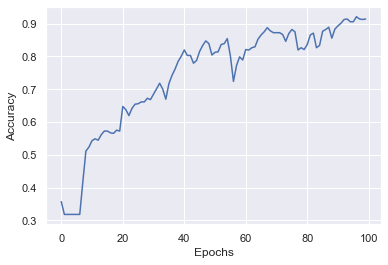

In [56]:
sn.lineplot(x=list(range(100)),y=crnn_history.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')

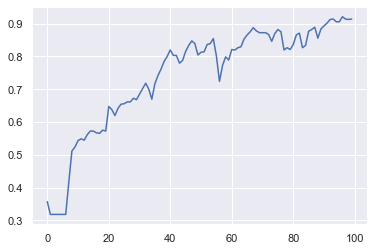

In [57]:
plt.plot(crnn_history.history['accuracy'])

In [58]:
accuracy = c_rnnModel.evaluate(X_test, y_test)

6/6 [==============================] - 1s 28ms/step - loss: 0.8050 - accuracy: 0.7667


<AxesSubplot:>

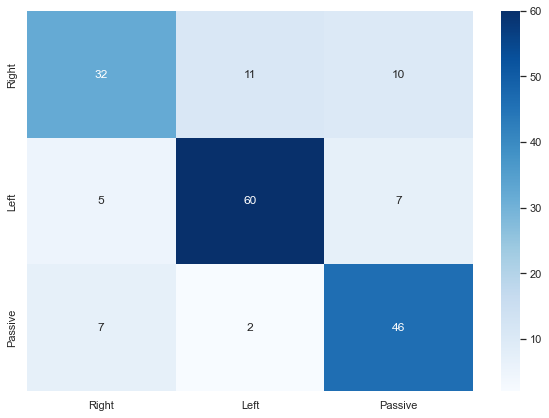

In [60]:
predictions = c_rnnModel.predict(X_test)
y_pred = [p.argmax() for p in predictions]
y_true = [y.argmax() for y in y_test]
conf_mat = confusion_matrix(y_true,y_pred)
df_conf = pd.DataFrame(conf_mat,index=[i for i in 'Right Left Passive'.split()],
                      columns = [i for i in 'Right Left Passive'.split()])
plt.figure(figsize = (10,7))
sn.heatmap(df_conf, annot=True,cmap='Blues')

In [63]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           1       0.73      0.60      0.66        53
           2       0.82      0.83      0.83        72
           3       0.73      0.84      0.78        55

    accuracy                           0.77       180
   macro avg       0.76      0.76      0.76       180
weighted avg       0.77      0.77      0.76       180

